# Classification binaire : Chiens _vs._ Chats

Dans ce TP, on s'intéresse au problème simple (en apparence) de reconnaître des chiens et des chats dans des images.

<center><img src="img/catdogdataset.png" style="width:1000;height:550px;"></center>
<caption><center><b> Figure 1 : Quelques images de la base de données </b></center></caption>

Pour cela nous allons utiliser une base de données de 4000 images, réparties en 2000 images d'apprentissage, 1000 images de validation, et 1000 images de test. Compte-tenu de la variabilité possible des représentations de chiens et chats, cette base de données est d'une taille assez réduite et le problème est complexe. Il correspond bien aux problèmes que nous pouvons rencontrer dans la réalité, lorsque les données sont souvent difficiles à obtenir.


In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras

from tensorflow.keras import optimizers
from tensorflow.keras import Input
from keras import layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-09-02 15:49:49.943419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chargement des données  <a id='data_load'></a>

Les cellules suivantes permettent de charger les données dans un format adapté. Ne passez pas trop de temps dessus dans un premier temps, nous reviendrons dessus dans la partie "[validation croisée](#cv)".

In [ ]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/cats-vs-dogs.git

In [2]:
import shutil

path = "./cats-vs-dogs/"

* Création de _listes_ contenant les noms des images des ensemble d'apprentissage, de validation et de test, ainsi que les label (0: chat, 1:chien) associés

In [3]:
#Images d'entrainement
train_filenames_dogs = os.listdir(path + "train/dogs")
train_filenames_cats = os.listdir(path + "train/cats")
if not os.path.exists(path + "train/train"):
    os.mkdir(path + "train/train")

path_train = path + "train/"
for filename in train_filenames_cats:
    shutil.copyfile(path_train+"cats/"+filename, path_train+"train/"+filename)
for filename in train_filenames_dogs:
    shutil.copyfile(path_train+"dogs/"+filename, path_train+"train/"+filename)

train_filenames = os.listdir(path + "train/train")
train_categories =[]
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        train_categories.append(1)
    else:
        train_categories.append(0)

        
#Images de validation
validation_filenames = os.listdir(path +"validation/")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        validation_categories.append(1)
    else:
        validation_categories.append(0)

        
#Images de test
test_filenames = os.listdir(path + "test/")
test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)

* Création de _DataFrames_ pour permettre, plus loins, de charger les données au fur et à mesure des besoins.

In [4]:
#Images d'entrainement
train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})


#Images de validation
validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


#Images de test
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


train_df['category'] = train_df['category'].astype(str)
validation_df['category'] = validation_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

##### <i style="color:purple">**Question** : Le jeu de données est-il équilibré ?</i>

In [ ]:
## A COMPLETER ##

In [ ]:
# %load solutions/cats-vs-dogs/ratio.py

### Visualisation des images

In [5]:
import random
from tensorflow.keras.utils import load_img

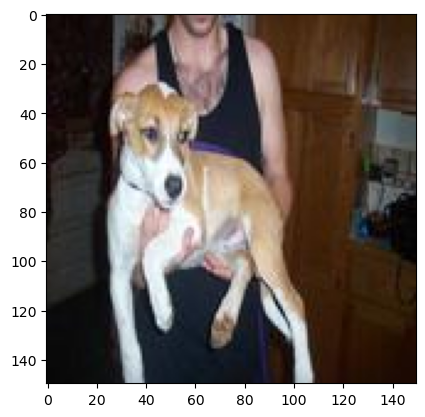

In [6]:
sample = random.choice(test_filenames)
image = load_img(path + "test/" + sample)

plt.imshow(image)
plt.show()

### Prétraitement des images

La syntaxe ci-dessous définit pour chaque ensemble de données des "generateurs" qui permettent de charger un nombre prédéfini d'images (ce sera notre taille de batch) à partir des _DataFrames_ définis précédemment. 

On définit également une dimension cible des images (ici, 150x150) et un pré-traitement de normalisation (division par 255).

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 16
image_size = 150

#Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path + "train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (image_size,image_size),
    class_mode = 'binary',
    batch_size = batch_size
)

#Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    path + "validation/", 
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size = batch_size
)

#Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    path + "test/", 
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [9]:
labels= {0: 'Chat', 1: 'Chien'}
labels.get(0), labels.get(1)

('Chat', 'Chien')

##### <i style="color:purple">**Exercice** : Visualiser un échantillon d'images.</i>

Selectionner 9 images du jeu de données d'entraînement, et les afficher avec leur label respectif en guise de titre. Le code ci-dessous donne un exemple d'utilisation des générateurs définis précédement.

In [10]:
for X_batch, Y_batch in validation_generator:
    print(X_batch.shape)
    print(Y_batch.shape)
    print(Y_batch)
    break

(16, 150, 150, 3)
(16,)
[0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1.]


In [ ]:
## A COMPLETER ##
plt.figure(figsize=(12, 12))

[...]
        
plt.tight_layout()
plt.show()

In [ ]:
# %load solutions/cats-vs-dogs/data_visualization.py

## Première approche : réseau convolutif de base

Les images ont toutes été redimensionnées en $150\times150$. Nous pouvons donc définir notre réseau de neurones convolutif en suivant ce schéma :

<center> <img src="img/CatsandDogsCNN.png" style="width:800;height:400px;"></center>
<!-- <center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center> -->
<caption><center><b> Figure 2: Vue de l'architecture à implémenter </b></center></caption>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2).

* La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128.
* Enfin, avant la couche de sortie, vous ajouterez une couche dense comptant 512 neurones.

Vous aurez donc construit un réseau à 6 couches, sorte de version simplifiée d'AlexNet.

Pour construire ce réseau, vous pouvez utiliser les fonctions _Conv2D_, _Maxpooling2D_, et _Flatten_ de `Keras`.

In [ ]:
## A COMPLETER ##

model = models.Sequential()

# model.add(Input(...))
# model.add(Conv2D(...))
# model.add(MaxPooling2D(..))
# ...
# model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
# ...

In [12]:
# %load solutions/cats-vs-dogs/CNN_model.py

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,397,793 (12.96 MB)

 Trainable params: 3,397,793 (12.96 MB)

 Non-trainable params: 0 (0.00 B)

La commande ci-dessus doit rendre l'affichage suivant (aux noms des couches près) :

``````Python
Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,397,793 (12.96 MB)

 Trainable params: 3,397,793 (12.96 MB)

 Non-trainable params: 0 (0.00 B)

```

_Remarque_ : La fonction plot_model permet de visualiser un réseau de neurones créé avec keras.

In [ ]:
from keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

### Entrainement

Pour l'entraînement, vous pouvez utiliser directement les hyperparamètres suivants.

In [14]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

In [15]:
model.metrics_names

['loss', 'compile_metrics']

In [18]:
tf.__version__

'2.16.2'

... puis lancer l'entraînement. **Attention : si jamais vous voulez relancer l'entraînement, il faut réinitialiser les poids du réseau. Pour cela il faut re-exécuter les cellules précédentes à partir de la définition du réseau !** Sinon vous risquez de repartir d'un entraînement précédent (qui s'est éventuellement bien, ou mal déroulé) et mal interpréter votre nouvel entraînement.

In [ ]:
history = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    epochs=10)

### Analyse des résultats du modèle

##### <i style="color:purple">**Exercice** : Visualiser l'évolution des métriques au cours de l'entraînement.</i>

Ecire une fonction affichant l'évolution des métriques au cours de l'entraînement, sur les ensembles d'apprentissage et de validation. Afficher l'accuracy et la loss sur des figures distinctes.

In [ ]:
def plot_training_analysis():
    [...]

In [ ]:
# %load solutions/cats-vs-dogs/plot_training_analysis.py

In [ ]:
plot_training_analysis()

### Correction du surapprentissage

Vous devriez maintenant reconnaître le problème auquel vous avez affaire : **le surapprentissage**. Ce problème est classique dès lors que l'on travaille sur des bases de données de taille réduite en apprentissage profond.
En effet, le réseau que vous avez créé compte normalement (si vous avez suivi les indications) plus de trois millions de paramètres. Le problème que vous essayez de résoudre pendant l'entraînement consiste à établir 3 millions de paramètres avec seulement 2000 exemples : c'est trop peu !

Afin de limiter ce surapprentissage, nous pouvons appliquer les techniques de régularisation vues pendant le 2nd cours. En traitement d'image, une des techniques les plus couramment utilisées est **l'augmentation de la base de données**.

Nous allons reprendre l'_ImageDataGenerator_ créé précédemment pour normaliser les images et l'utiliser  pour appliquer des transformations supplémentaires aux images de notre base de données. A vous de chercher dans la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) à quoi correspondent les différents paramètres présentés ci-dessous.

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path + 'train/train/',
    x_col ='filename',
    y_col ='category',
    target_size=(image_size,image_size),
    class_mode = 'binary',
    batch_size = batch_size
)

La cellule suivante vous permet de visualiser des images passées à travers notre boucle d'augmentation de données. Observez comment les valeurs manquantes sur les images (par exemple, dans le cas d'une rotation) sont comblées.

In [ ]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

Nous pouvons maintenant recréer notre modèle et relancer l'entraînement.

In [ ]:
## A COMPLETER ##
model = models.Sequential()
[...]

model.summary()


## A COMPLETER ##
model.compile(...)

history = model.fit(
    train_generator_augmented, 
    validation_data = validation_generator,
    epochs = 50
)

In [ ]:
# %load solutions/cats-vs-dogs/CNN_model.py

In [ ]:
# %load solutions/cats-vs-dogs/CNN_train.py

### Analyse des résultats

In [ ]:
plot_training_analysis()

On voit clairement sur les courbes que l'on a limité le sur-apprentissage. Notez aussi d'ailleurs, et c'est important, que l'apprentissage est plus lent : le modèle met plus de temps à prédire correctement l'ensemble d'apprentissage. C'est normal, car on a en quelque sorte "complexifié le problème" en introduisant toutes ces déformations de nos images.
Cette forme de régularisation "par les données" s'ajoute aux autres méthodes que nous avons vues précédemment comme la régularisation L1/L2 des poids du réseau et le Dropout.  

Vous devriez maintenant atteindre des performances autour de 80% de précision sur l'ensemble de validation, ce qui est bien mais pas complètement satisfaisant : il faudrait pour continuer à s'améliorer probablement s'entraîner plus longtemps, mais également disposer de plus de données.

Une autre solution est d'utiliser le **Transfer Learning**.

## Transfer learning

L'une des raisons qui peut expliquer le fait que nos résultats soient décevants est que les premières couches de notre réseau convolutif, sensées détecter des caractéristiques utiles pour discriminer chiens et chats, n'ont pas appris de filtres suffisamment généraux à partir des 2000 images d'entraînement. Ainsi, même si ces filtres sont pertinents pour les 2000 images d'entraînement, il y a en fait assez peu de chances que ces filtres puissent bien fonctionner pour la généralisation sur de nouvelles données.

C'est la raison pour laquelle nous avons envie de réutiliser un réseau pré-entrainé sur une large base de données, permettant donc de détecter des caractéristiques qui généraliseront mieux à de nouvelles données.

Dans cette partie, nous allons réutiliser un réseau célèbre, et d'ores et déjà entraîné sur la base de données ImageNet : le réseau VGG-16.

Commençons par récupérer les couches de convolution de ce réseau, et s'en remémorer  la composition.

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = VGG16(
    weights = 'imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
    include_top = False, # On ne conserve pas la partie Dense du réseau originel
    input_shape = (150, 150, 3)
)

In [ ]:
conv_base.summary()

Nous pouvons extraire les caractéristiques, apprises par le réseau de neurones sur ImageNet, de notre base de données d'image de chiens et de chat. L'intérêt, par rapport à la première partie, est qu'il aurait été presque impossible de déduire ces caractéristiques "générales" (trouvées sur une immense base de données) depuis notre base de données trop réduite de 2000 images. En revanche, ces caractéristiques générales devraient se révéler utiles pour notre classifieur.

On peut lire sur la structure du réseau VGG résumée grâce à la fonction *summary* ci-dessus que le tenseur de sortie est de dimension $4 \times 4 \times 512$, autrement dit que le réseau prédit des caractéristiques de dimension $4 \times 4 \times 512$ à partir d'une image de taille $150 \times 150$.

On va redimensionner cette sortie dans un vecteur de dimension $8192 = 4 \times 4 \times 512$. 

In [ ]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0],4*4*512))

val_features = conv_base.predict(validation_generator)
val_features = np.reshape(val_features,(val_features.shape[0],4*4*512))

Il nous faut également récupérer les labels associés ; nous allons les chercher dans la dataframe définie au début du TP.

In [ ]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = validation_df.to_numpy()
y_val = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

Nous pouvons maintenant définir un réseau de neurones simple qui va travailler directement sur les caractéristiques prédites par VGG.

In [ ]:
model = models.Sequential()
model.add(Input(shape=(4*4*512,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=3e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_features, y_train,
    epochs = 50,
    batch_size = 16,
    validation_data = (val_features, y_val)
)

In [ ]:
plot_training_analysis()

On observe à nouveau beaucoup de sur-apprentissage. Il faudrait trouver un moyen d'intégrer de l'augmentation de données. 

Pour cela, on peut connecter notre petit réseau de neurones à l'extrémité de la base convolutionnelle de VGG. L'idée est qu'en réutilisant notre générateur de données augmentées, nous pourrons calculer les caractéristiques de VGG sur les données augmentées, et ainsi classifier ces caractéristiques plutôt que les caractéristiques de notre base de données uniquement.

## Transfer learning & Augmentation de données

### Définition du nouveau modèle et entrainement

On commence par créer un nouveau modèle qui va s'appuyer sur la base convolutive de VGG, à laquelle on adjoint une couche dense et notre couche de sortie.

In [ ]:
model = models.Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

**Attention** : il est important de ne pas commander l'entraînement de la base convolutionnelle de VGG ! Nous ne voulons en aucun cas écraser les bonnes caractéristiques de VGG que nous cherchons justement à réutiliser ! Le réseau aurait en outre un grand nombre de paramètres, ce qui est justement ce que l'on veut éviter ! 

Pour cela nous pouvons utiliser l'attribut *trainable* : en le positionnant à *false*, nous pouvons geler les poids et en empêcher la mise à jour pendant l'entraînement.

In [ ]:
conv_base.trainable = False
model.summary()

Observez le décompte des poids : le nombre de poids entraînable est maintenant à 2 millions, contre 16 millions précédemment ; on ne va entrainer ici que les poids de notre couche dense et de la couche de sortie.

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 10,
    validation_data = validation_generator
)

### Analyse des résultats du nouveau modèle

L'entraînement est beaucoup plus lent ! Il faut en effet générer les données augmentées, et leur faire traverser les couches de VGG à chaque itération de gradient. Ceci prend du temps !

In [ ]:
plot_training_analysis()

En revanche, on observe que l'on a bien limité le sur-apprentissage, ce qui était le but recherché. Cela améliore considérablement les résultats !

### Fine-tuning


Nous pouvons maintenant tester la dernière technique vue en cours : le **fine-tuning**. Pour cela, nous allons repartir du réseau que nous venons d'entraîner, mais nous allons débloquer l'entraînement des poids de l'ensemble du réseau. **ATTENTION : il est important de choisir un taux d'apprentissage très faible afin de ne pas réduire à néant les bénéfices des entraînements précédents.** L'objectif est simplement de faire évoluer les paramètres du réseau "à la marge", et ceci ne peut être fait qu'après la première étape de *transfer learning* précédente. Sans cela, les dernières couches ajoutées à la suite de la base convolutive, après leur initialisation aléatoire, auraient engendré de forts gradients qui auraient complètement détruit les filtres généraux de VGG.



On commence par réactiver l'entraînement des paramètres de la base convolutive de VGG : 

In [ ]:
conv_base.trainable = True
model.summary()

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
    metrics = ['accuracy']
)

history = model.fit(
    train_generator_augmented,
    epochs = 10,
    validation_data = validation_generator
)

In [ ]:
plot_training_analysis()

On atteint l'excellent résultat de 97% de précision sur l'ensemble de validation, bien au-dessus des performances obtenues sans *transfer learning* ! Vous comprenez maintenant pourquoi en traitement d'image, cette technique est incontournable.

## Global Average Pooling

En réalité, on utilise plus vraiment la couche _Flatten_ aujourd'hui pour faire le lien entre couches convolutives et couches denses, mais plutôt une couche de [GlobalAveragePooling](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/). Essayez de comprendre ce que fait cette couche et de modifier le réseau construit par dessus VGG en conséquence. 

In [ ]:
## A COMPLETER ##

In [ ]:
# %load solutions/cats-vs-dogs/GlobalAveragePooling_model.py

In [ ]:
# %load solutions/cats-vs-dogs/GlobalAveragePooling_train.py

In [ ]:
# %load solutions/cats-vs-dogs/GlobalAveragePooling_tune.py

## Validation croisée <a id='cv'></a>

Afin de s'assurer que les performances précédentes ne dépendent pas de notre découpage ensemble d'entraînement/ensemble de validation, nous allons mettre en place une validation croisée. Nous devrions normalement obtenir des performances similaires pour chaque split.

In [ ]:
from sklearn.model_selection import KFold

##### <i style="color:purple">**Exercice** : Preparer les données.</i>

En vous inspirant des blocs de la section "[chargement des données](#data_load)",
* Créez (s'il n'existe pas déjà) un dossier `cv` à la racine de `cats-vs-dogs`,
* Copiez l'ensemble des images d'entraînement et de validation dans ce dossier,
* Créez un _DataFrame_ `cv_df` rassemblant le nom des fichiers et leur label associé, pour l'ensemble des images contenues dans le dossier `cv`. 

Les 5 premières lignes de `cv_df` devraient ressembler à :
``` 
       filename  category
0 	dog.775.jpg 	1
1 	cat.952.jpg 	0
2 	cat.946.jpg 	0
3 	dog.761.jpg 	1
4 	dog.991.jpg 	
```

In [ ]:
## A COMPLETER ##

[...]

categories = ...

[...]

cv_df = ...
cv_df.head()

In [ ]:
# %load solutions/cats-vs-dogs/cv_load_data.py

##### <i style="color:purple">**Exercice** : Instancier un réseau de neurones.</i>

Ecrire une fonction `create_new_model` qui instancie un des réseaux au choix ci-dessus. À chaque nouveau split de la validation croisée, nous allons réaliser un appel à cette fonction.

Dans un premier temps, choisissez un réseau **simple** et pas trop long à entraîner pour pouvoir lancer plusieurs fois sans trop perdre de temps la validation croisée (utile en cas de bugs...).

In [ ]:
def create_new_model(image_size=150):
    [...]

In [ ]:
# %load solutions/cats-vs-dogs/create_new_model.py

In [ ]:
model = create_new_model()
# model.summary()

La fonction suivante permet d'obtenir le nom du modèle pour chacun des splits de la validation croisée.

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.keras'

Enfin, nous créons un dossier `saved_models` à la racine de `TP3` dans lequel nous allons stocker les poids des modèles obtenus pour chaque split.

In [ ]:
if not os.path.exists("saved_models/"):
    os.mkdir("saved_models")

Nous pouvons à présent mettre en oeuvre la validation croisée.

##### <i style="color:purple">**Exercice** : Réaliser la validation croisée.</i>

Pour cela, complétez le code ci-dessous. Quelques **indications** :

* `n_folds` désigne ne nombre de split.

* `train_df` désigne un _DataFrame_ contenant uniquement les images de _train_ pour le split courrant. <br>
De même pour `validation_df`.

* Au besoin, on pourra consulter la documentation : [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

* `train_generator` désigne le générateur associé aux données d'entraînement. Pour le consruire, on pourra utiliser la commande [flow_from_dataframe](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) dont un exemple d'utilisation est donné dans la partie "[chargement des données](#data_load)". <br>
De même pour `validation_generator`.

* Pour éviter le sur-apprentissage, faire de l'[augmentation de données](#data_augmented).

* En utilisant la fonction [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint), enregistrez des points de contrôle (checkpoints). 
    * Les modèles sont à sauvergarder dans le dossier `saved_models` préalablement créé, 
    * Nous voulons, à chaque étape, monitorer l'accuracy de validation, en ne gardant que la plus élevée. 
    * Enfin, pour suivre l'évolution de l'entraînement, nous allons afficher des messages lorsque le callback effectue une action. 
    <br>$~$
    
* La fonction [load_weights](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=fr) permet de charger les poids d'un modèle pré-enregistré.

In [ ]:
## A COMPLETER ##

tf.keras.backend.clear_session()

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

n_folds = 3
kf = KFold(...)  # A COMPLETER

save_dir = './saved_models/'

for fold_no, (train_index, validation_index) in enumerate(kf.split(np.zeros(len(categories)), categories)):
    train_df = ...  # A COMPLETER : images de *train* pour ce split
    validation_df = ...  # A COMPLETER : images de *validation* pour ce split
    
    train_generator = ...  # A COMPLETER : Generateur, données d'entrainement
    
    validation_generator = ...  # A COMPLETER : Generateur, données de validation

    # CREATE NEW MODEL
    model = ...  # A COMPLETER : Instancier un nouveau model
    
    # COMPILE NEW MODEL
    [...]
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'## Training for fold {fold_no+1}/{n_folds} ##')

    # CREATE CALLBACKS
    checkpoint = ...  # A COMPLETER
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    history = model.fit(
        train_generator,
        epochs = 10,
        callbacks = callbacks_list,
        validation_data = validation_generator)
    # Model weights are saved at the end of every epoch, if it's the best seen so far.

    # PLOT HISTORY
    plot_training_analysis()
    
    # LOAD BEST MODEL to evaluate the performance of the model
    [...]
    
    results = model.evaluate(validation_generator)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

In [ ]:
# %load solutions/cats-vs-dogs/CrossValidation.py

##### <i style="color:purple">**Question** : Les performances semblent-elles dépendre du découpage train/val ?</i>

On pourra répondre à cette question à l'aide de boxplot.

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
# %load solutions/cats-vs-dogs/consistency.py

## Utilisation d'un autre réseau <b style="color:crimson">(pour aller plus loin)</b>

Essayez de charger d'autres modèles que VGG16 au début de ce TP. Vous trouverez sur la doc de Keras [une liste des modèles utilisables](https://keras.io/api/applications/). Vous pouvez par exemple tester des réseaux plus avancés, que vous verrez dans la suite du cours, comme par exemple _Inception_ et _ResNet_. Quel réseau fournit les meilleurs résultats ? 

Attention à bien lire la documentation, certains réseaux comme _EfficientNet_ prennent en entrée des images non normalisées, ce qui nécessite des modifications dans l'ImageDataGenerator défini plus haut.

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
## A COMPLETER ##

In [ ]:
# %load solutions/cats-vs-dogs/ResNet_model.py

In [ ]:
# %load solutions/cats-vs-dogs/ResNet_train.py

In [ ]:
# %load solutions/cats-vs-dogs/ResNet_tune.py